In [1]:
# import packages
import matplotlib.pyplot as pl
import scanpy as sc
import scvelo as scv
import loompy as lmp
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import cellrank as cr
import warnings
import seaborn as sns
import os
import sys
from anndata import AnnData


# set verbosity levels
sc.settings.verbosity = 2
cr.settings.verbosity = 2
scv.settings.verbosity = 3 

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [33]:
#set color palette
colors = sns.color_palette('bright', 11)
colors
TNcdict = {'Tumor Corticotrophs':colors[3], 'Normal Corticotrophs':colors[0], "FSC":colors[4]}
ct_dict = {"Corticotrophs": colors[3],
          'Somatotrophs': colors[0],
          "Lactotrophs": colors[1],
          "Gonadotrophs": colors[2],
          'FSC': colors[4],
          "Endothelial": colors[5],
          'Fibroblasts': colors[6],
          'unassigned': colors[7],
          'Macrophages': colors[8],
          'POU1F1+':colors[9],
          "T-cells":colors[10]}


color_macro = ["tab:brown", "tab:red","tab:gray", "tab:orange", "tab:purple", "tab:pink", "tab:blue", "tab:green"]

color_macro


['tab:brown',
 'tab:red',
 'tab:gray',
 'tab:orange',
 'tab:purple',
 'tab:pink',
 'tab:blue',
 'tab:green']

In [11]:
adata.obs["pred.type"]

AAACAGCCAAAG    Corticotrophs
AAACAGCCAAAT    Corticotrophs
AAACAGCCACAA    Corticotrophs
AAACAGCCACTC     Somatotrophs
AAACAGCCATTG    Corticotrophs
                    ...      
TTTGTGGCAGAA      Lactotrophs
TTTGTGGCAGCT      Lactotrophs
TTTGTGGCAGTT    Corticotrophs
TTTGTGTTCGGT    Corticotrophs
TTTGTTGGTCTT    Corticotrophs
Name: pred.type, Length: 7888, dtype: category
Categories (11, object): ['Corticotrophs', 'Endothelial', 'FSC', 'Fibroblasts', ..., 'POU1F1+', 'Somatotrophs', 'T-cells', 'unassigned']

# Load and Merge Tumor Data with Spliced and Unspliced Counts

In [31]:
adata=scv.read("/Users/bhattda/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/test_data/processed/m1_T.h5ad")
ldata=scv.read("/Users/bhattda/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/test_data/Stoica_S1_outs_comb_gex_possorted_bam_7EH3V.loom",cache=True)
scv.utils.clean_obs_names(adata)
scv.utils.clean_obs_names(ldata)
adata.obs["pred.type"] = adata.obs["scpred_prediction"]
adata = scv.utils.merge(adata, ldata)
#save combined anndata file 
sc.write("adata_original.h5ad", adata) 

... reading from cache file cache/Users-bhattda-Library-CloudStorage-OneDrive-NationalInstitutesofHealth-test_data-Stoica_S1_outs_comb_gex_possorted_bam_7EH3V.h5ad


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# All Cell Type Analysis

<font size="5">Preproccess data and compute UMAP</font>

In [34]:
adata= sc.read_h5ad("adata_original.h5ad")
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata, color='pred.type', palette=ct_dict)

KeyboardInterrupt: 

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


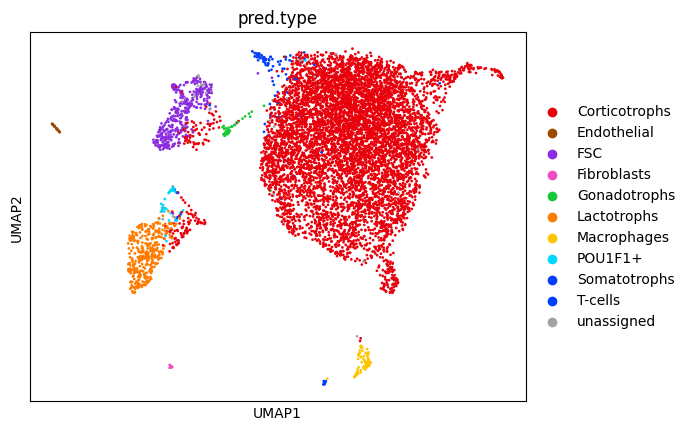

In [35]:
sc.pl.umap(adata, color='pred.type', palette=ct_dict)

<font size="5">Compute RNA Velocity</font>

In [36]:
scv.pp.filter_and_normalize(adata, min_shared_counts =20, n_top_genes=2000)
scv.pp.moments(adata,n_pcs=30, n_neighbors=30)
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode= "dynamical")
scv.tl.velocity_graph(adata)

Filtered out 28515 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/8 cores)


  0%|          | 0/753 [00:00<?, ?gene/s]

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:02:10) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/7888 [00:00<?, ?cells/s]

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:12) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


<font size="5">Display RNA Velocity</font>

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


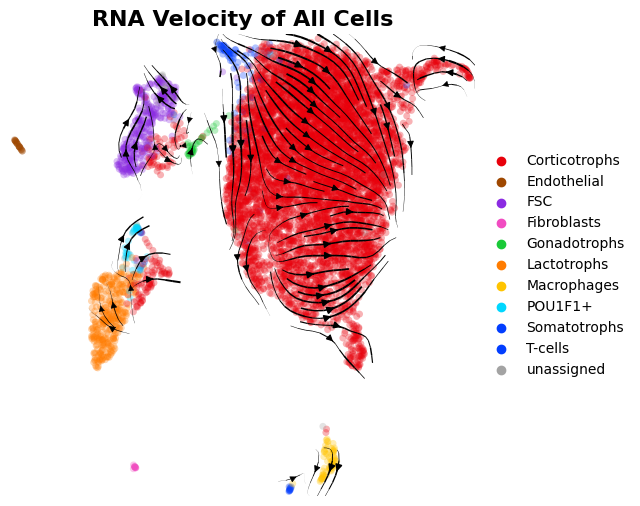

In [37]:
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
ax1_dict = scv.pl.velocity_embedding_stream(adata, basis= "umap", color="pred.type",  size = 100, dpi =600,
                                            legend_loc="top right", ax= ax1, show = False, palette=ct_dict)
ax1.set_title("RNA Velocity of All Cells", fontweight="bold", fontsize=16)
    
pl.savefig("All_Cell_RNA_Velocity.png")

# FSC and Corticotrophs Analysis

<font size="5">Import, Filter for FSC and Coritcotrophs,  and Preprocess Data</font>

In [41]:
adata= sc.read_h5ad("adata_original.h5ad")
adata = adata[(adata.obs['pred.type'] == "Corticotrophs") | (adata.obs['pred.type'] == "FSC")    ]
adata

View of AnnData object with n_obs × n_vars = 7195 × 36591
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'anno', 'percent.mt', 'scpred_Macrophages', 'scpred_Somatotrophs', 'scpred_Corticotrophs', 'scpred_Lactotrophs', 'scpred_Gonadotrophs', 'scpred_POU1F1_plus', 'scpred_FSC', 'scpred_Fibroblasts', 'scpred_Endothelial', 'scpred_T_minuscells', 'scpred_max', 'scpred_prediction', 'scpred_no_rejection', 'pANN_0.25_0.09_0', 'DF.classifications_0.25_0.09_0', 'RNA_snn_res.0.5', 'seurat_clusters', 'sample_batch', 'pred.type', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'distances'

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


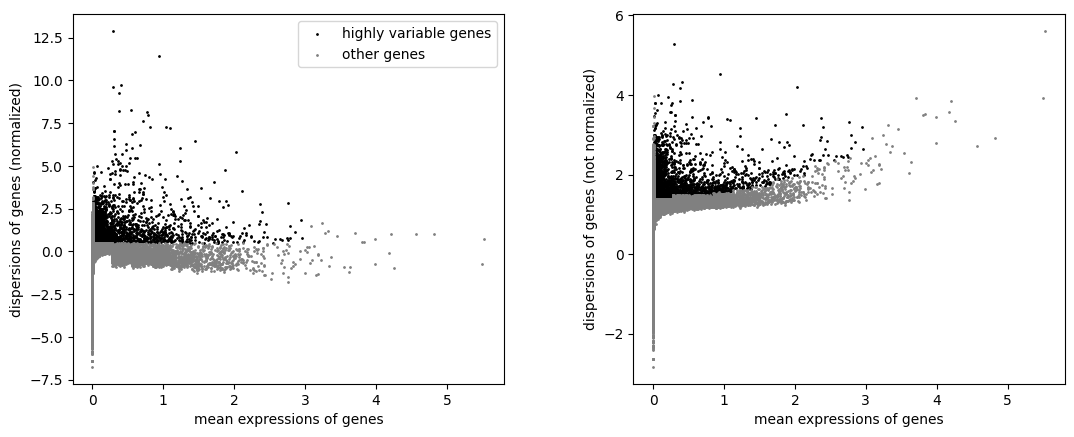

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


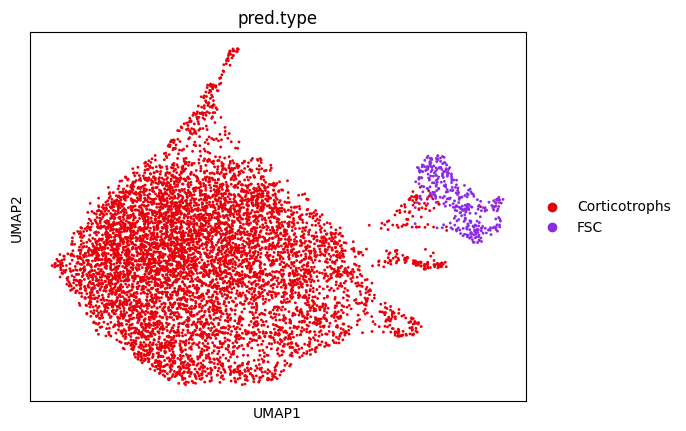

In [42]:
#Preproccess data and compute UMAP
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata, color='pred.type', palette=ct_dict)

<font size="5">Compute RNA Velocity</font>

In [43]:
scv.pp.filter_and_normalize(adata, min_shared_counts =2, n_top_genes=2000)
scv.pp.moments(adata,n_pcs=30, n_neighbors=30)
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode= "dynamical")
scv.tl.velocity_graph(adata)

Filtered out 24162 genes that are detected 2 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/8 cores)


  0%|          | 0/868 [00:00<?, ?gene/s]

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:02:01) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/7195 [00:00<?, ?cells/s]

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


<font size="5">Display RNA Velocity</font>

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


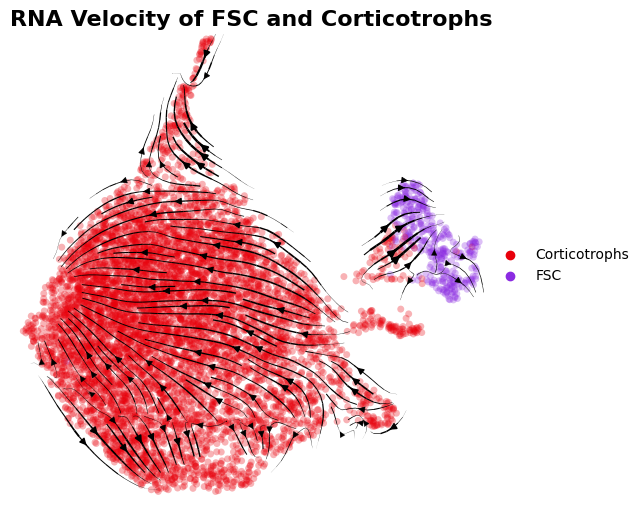

In [44]:
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
ax1_dict = scv.pl.velocity_embedding_stream(adata, basis= "umap", color="pred.type",  size = 100, dpi =600,
                                            legend_loc="top right", ax= ax1, show = False, palette=ct_dict)
ax1.set_title("RNA Velocity of FSC and Corticotrophs", fontweight="bold", fontsize=16)

    
pl.savefig("FSC_and_Corticotrophs_RNA_Velocity.png")

# Corticotrophs Analysis

<font size="5">Import, Filter for Coritcotrophs, and Preprocess Data</font>

In [136]:
adata= sc.read_h5ad("adata_original.h5ad")
adata=scv.read("/Users/bhattda/Library/CloudStorage/OneDrive-NationalInstitutesofHealth/test_data/processed/m1_T.h5ad")
adata.obs["pred.type"] = adata.obs["scpred_prediction"]
adata = adata[(adata.obs['pred.type'] == "Corticotrophs")  ]
adata

View of AnnData object with n_obs × n_vars = 6851 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'anno', 'percent.mt', 'scpred_Macrophages', 'scpred_Somatotrophs', 'scpred_Corticotrophs', 'scpred_Lactotrophs', 'scpred_Gonadotrophs', 'scpred_POU1F1_plus', 'scpred_FSC', 'scpred_Fibroblasts', 'scpred_Endothelial', 'scpred_T_minuscells', 'scpred_max', 'scpred_prediction', 'scpred_no_rejection', 'pANN_0.25_0.09_0', 'DF.classifications_0.25_0.09_0', 'RNA_snn_res.0.5', 'seurat_clusters', 'pred.type'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


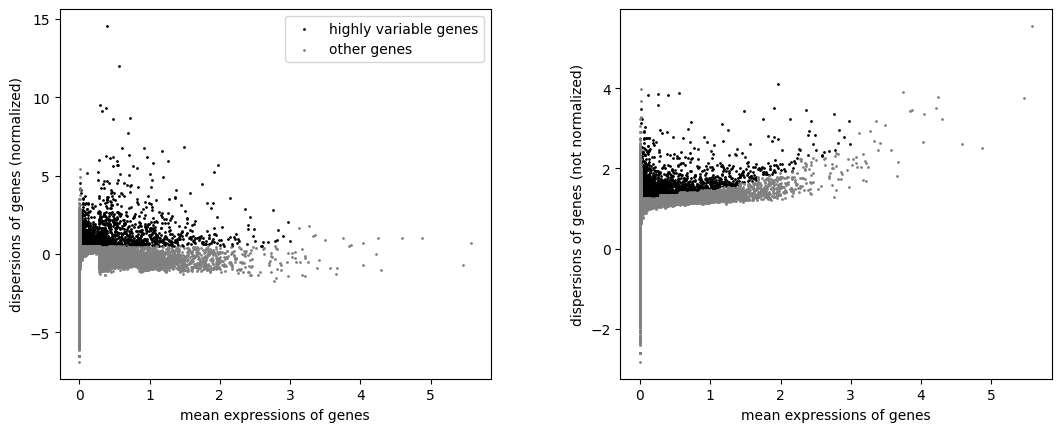

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


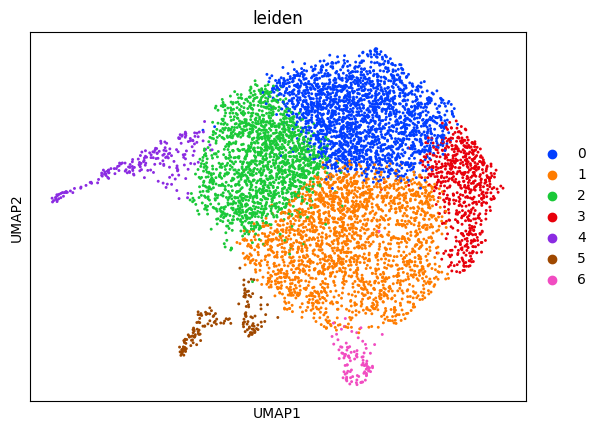

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


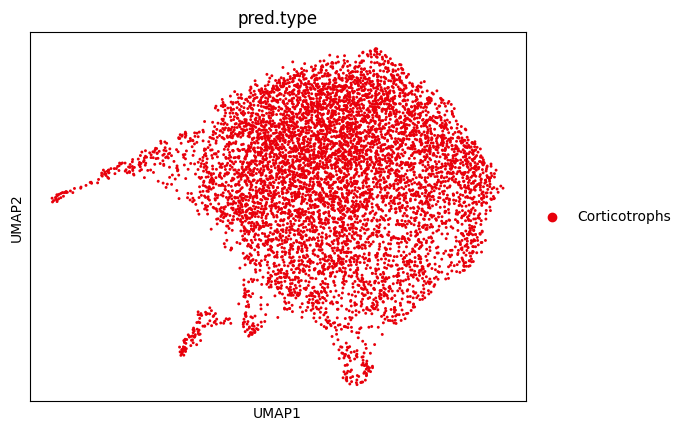

In [137]:
#preprocess and compute UMAP
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.leiden(adata, resolution=0.25)
sc.tl.umap(adata)
sc.pl.umap(adata, color='leiden', palette = colors)
sc.pl.umap(adata, color='pred.type', palette=ct_dict)
scv.utils.clean_obs_names(adata)
scv.utils.clean_obs_names(ldata)
adata = scv.utils.merge(adata, ldata)
#save combined anndata file 

<font size="5">Compute RNA Velocity</font>

In [138]:
scv.pp.filter_and_normalize(adata, min_shared_counts =20, n_top_genes=2000)
scv.pp.moments(adata,n_pcs=30, n_neighbors=30)
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode= "dynamical")
scv.tl.velocity_graph(adata)

Filtered out 28923 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/8 cores)


  0%|          | 0/262 [00:00<?, ?gene/s]

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:00:54) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/6851 [00:00<?, ?cells/s]

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [139]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()


Computing transition matrix using `'deterministic'` model


  0%|          | 0/6851 [00:00<?, ?cell/s]

Using `softmax_scale=6.2272`


  0%|          | 0/6851 [00:00<?, ?cell/s]

    Finish (0:00:04)


VelocityKernel[n=6851, model='deterministic', similarity='correlation', softmax_scale=6.227]

<font size="5">Display RNA Velocity</font>

Projecting transition matrix onto `umap`
Adding `adata.obsm['T_fwd_umap']`
    Finish (0:00:01)


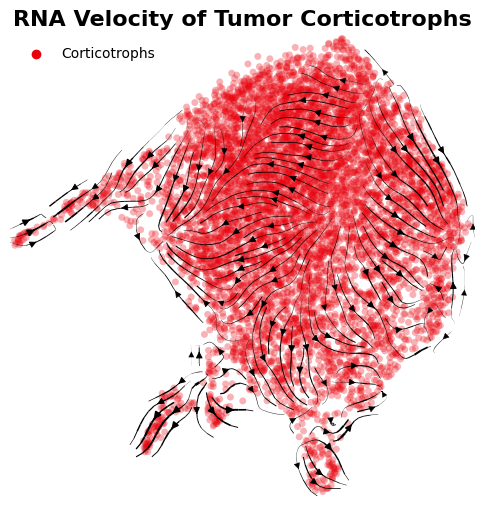

In [140]:
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
ax1_dict = vk.plot_projection( color="pred.type", size = 100, 
                   legend_loc='best',fontsize=16, legend_fontoutline = 5, ax= ax1, show= False,palette=ct_dict)
ax1.set_title("RNA Velocity of Tumor Corticotrophs", fontweight="bold", fontsize=16)
pl.savefig("Corticotrophs_RNA_Velocity.png")


Using precomputed projection `adata.obsm['T_fwd_umap']`


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


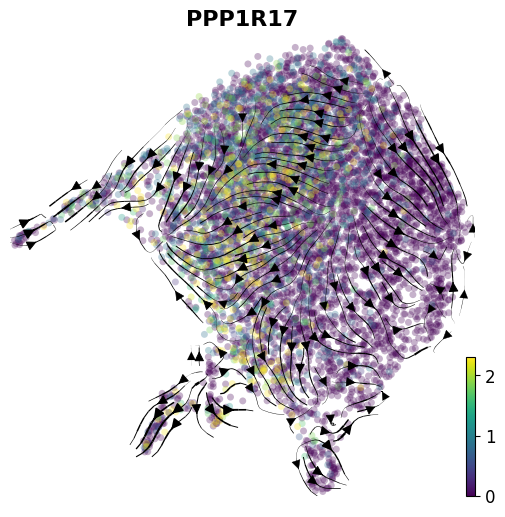

In [141]:
#embed RNA velocity over UMAP of gene expression of PPP1R17
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
ax1_dict = vk.plot_projection( color="PPP1R17", size = 100, 
                   legend_loc='best',fontsize=16, legend_fontoutline = 5, ax= ax1, show= False, vmax = 2.3, arrow_size=1.5, )
ax1.set_title("PPP1R17", fontweight="bold", fontsize=16)
pl.savefig("PPP1R17_RNA_Velocity.png")

Using precomputed projection `adata.obsm['T_fwd_umap']`


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


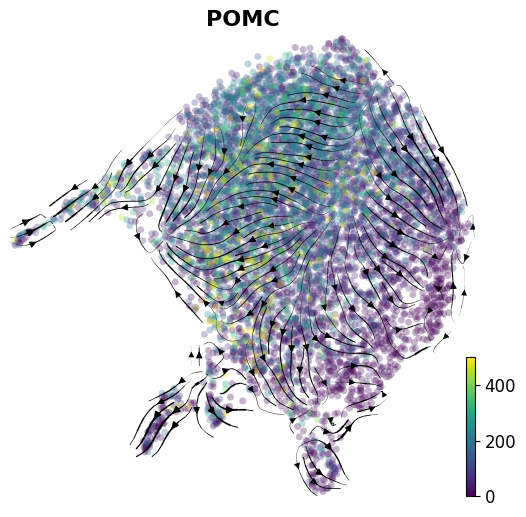

In [146]:
#embed RNA velocity over UMAP of gene expression of POMC
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
ax1_dict = vk.plot_projection( color="POMC", size = 100, 
                   legend_loc='best',fontsize=16, legend_fontoutline = 5, ax= ax1, show= False, vmax=500)
ax1.set_title("POMC", fontweight="bold", fontsize=16)
pl.savefig("POMC_RNA_Velocity.png")

Using precomputed projection `adata.obsm['T_fwd_umap']`


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


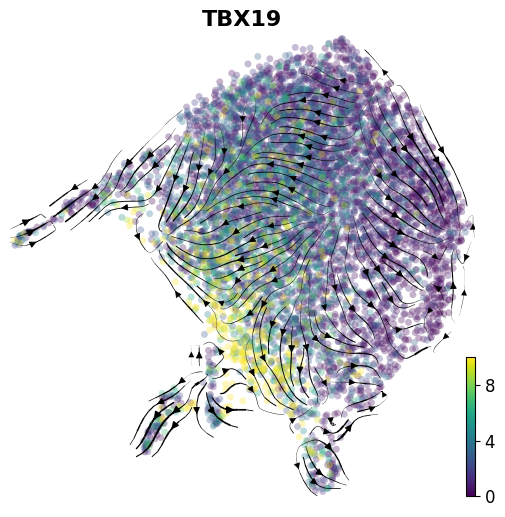

In [143]:
#embed RNA velocity over UMAP of gene expression of TBX19
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
ax1_dict = vk.plot_projection( color="TBX19", size = 100, 
                   legend_loc='best',fontsize=16, legend_fontoutline = 5, ax= ax1, show= False, vmax=10)
ax1.set_title("TBX19", fontweight="bold", fontsize=16)
pl.savefig("TBX19_RNA_Velocity.png")

In [144]:
g = cr.estimators.GPCCA(vk)
print(g)


GPCCA[kernel=VelocityKernel[n=6851], initial_states=None, terminal_states=None]


<font size="5">Compute Macrostates</font>

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:01:09)
Computing `9` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:05)


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


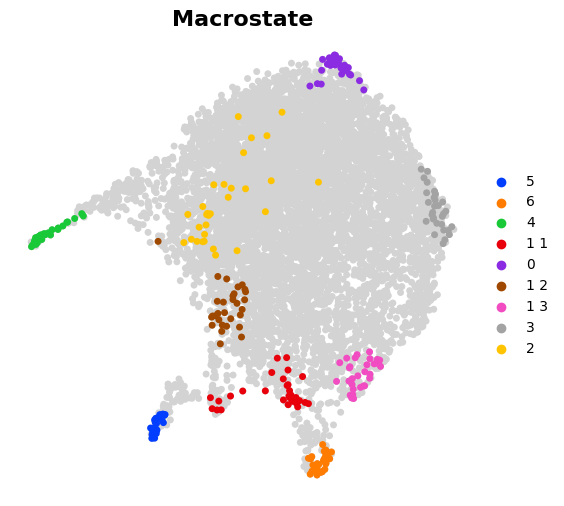

In [145]:
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
g.fit(cluster_key="leiden", n_states=9)
fig_kwargs = {"which":"all", 'legend_loc': 'right', 'discrete': True,'dpi':600, 
              'size': 100, "palette":colors, "ax":ax1, "show":False}
ax1_dict = g.plot_macrostates(**fig_kwargs)
ax1.set_title("Macrostate", fontweight="bold", fontsize=16)
pl.savefig("Macrostate.png")

In [147]:
adata.obs["macrostates"] = g.macrostates
g.macrostates_memberships.colors = colors[0:9]

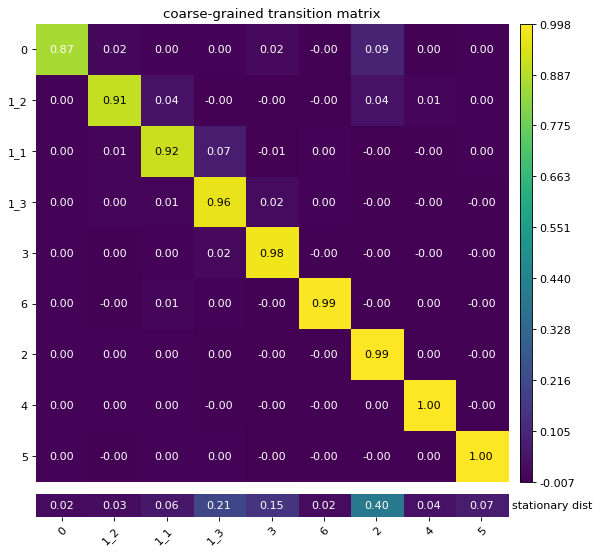

In [148]:
g.plot_coarse_T(save="macrostate_transition_matix.png")

<font size="5">Compute Terminal State</font>

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


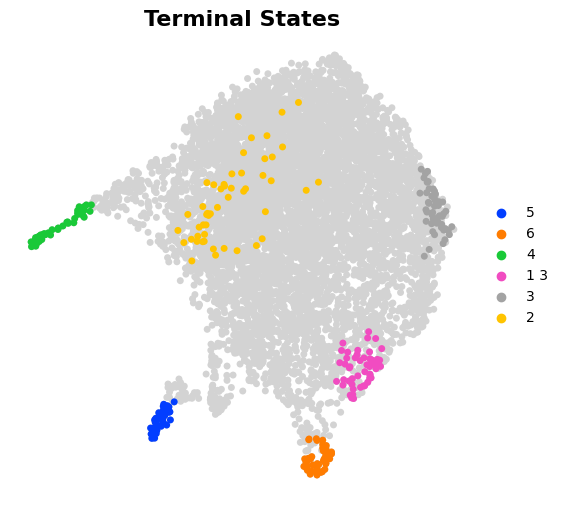

In [149]:
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
g.predict_terminal_states(stability_threshold=0.95, n_cells=50, allow_overlap=True )
fig_kwargs = {"which":"terminal", 'legend_loc': 'right', 'discrete': True, 'dpi':600, 'size': 100, 
              "ax":ax1, "show":False}
g.plot_macrostates(**fig_kwargs)
ax1.set_title("Terminal States", fontweight="bold", fontsize=16)
pl.savefig("Terminal_States.png")

<font size="5">Compute Initial State</font>

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


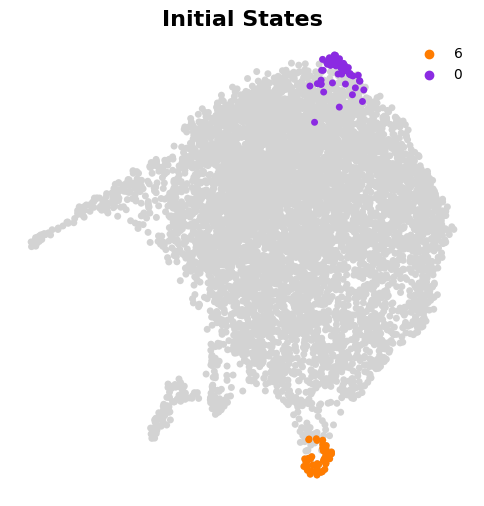

In [150]:
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
g.predict_initial_states(n_states=2, n_cells= 50, allow_overlap=True)
fig_kwargs = {"which":"initial", 'legend_loc': 'best', 'discrete': True, 'dpi':600, 
              'size': 100, "ax":ax1, "show":False}

g.plot_macrostates(**fig_kwargs)
ax1.set_title("Initial States", fontweight="bold", fontsize=16)
pl.savefig("Initial_States.png", dpi=600)

<font size="5">Compute Fate Probabilities</font>

Computing fate probabilities


  0%|          | 0/6 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_al

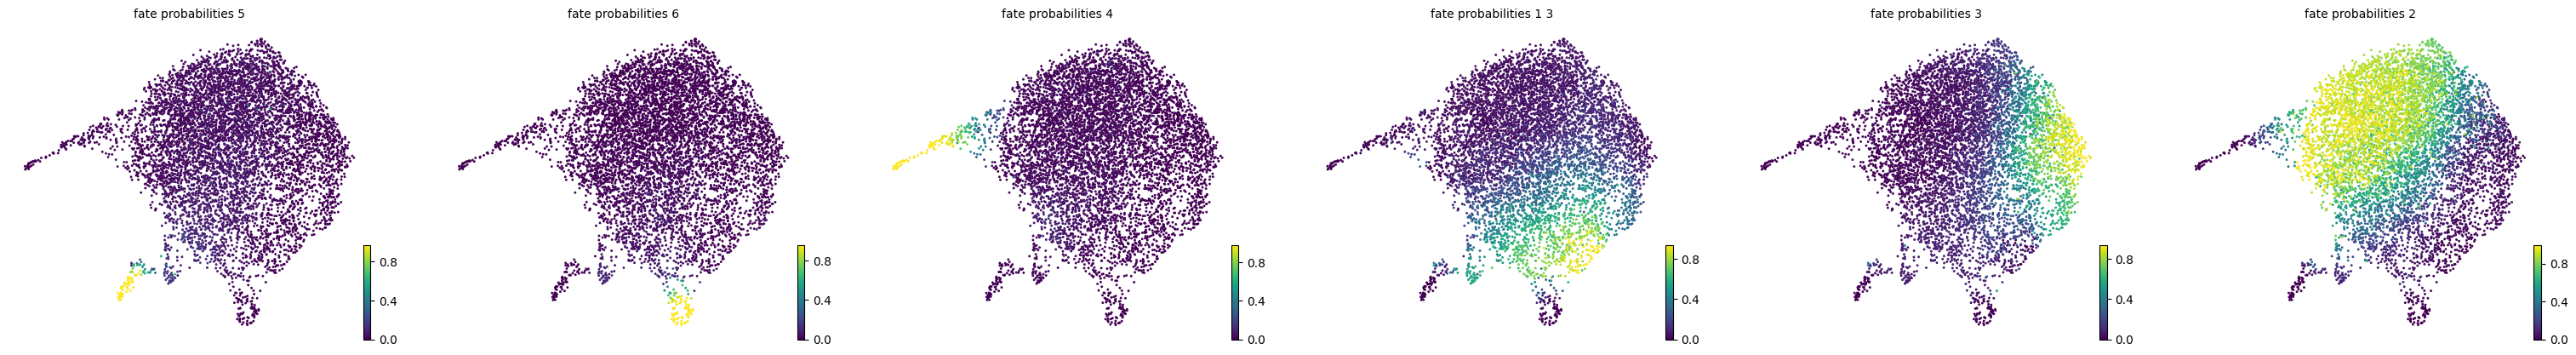

/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


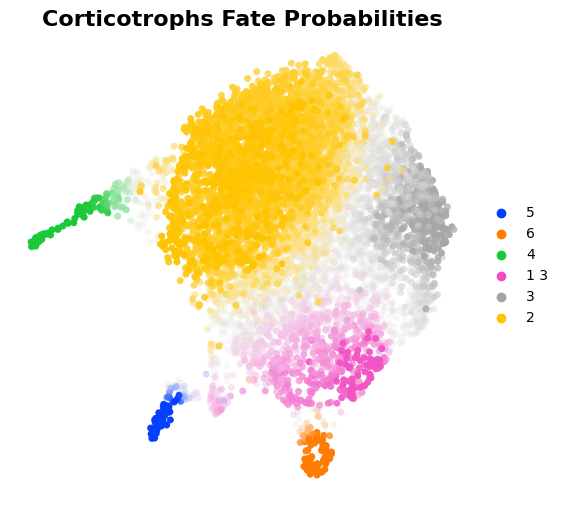

In [151]:
g.compute_fate_probabilities()
g.plot_fate_probabilities(same_plot=False)
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
fig_kwargs = {"same_plot": True, 'legend_loc': 'right', 'dpi':600, 'size': 100, 
              "fontsize": 16, "ax":ax1, "show":False}
g.plot_fate_probabilities(**fig_kwargs)
ax1.set_title("Corticotrophs Fate Probabilities", fontweight="bold", fontsize=16)
pl.savefig("Fate_Probabilities.png", dpi=600)

<font size="5">Compute Lineage Gene Drivers</font>

In [152]:
driver_df= pd.DataFrame()
driver_df = g.compute_lineage_drivers(use_raw=True)
driver_df.to_csv("P4_merge_gene_drivers.csv")

Adding `adata.raw.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:01)


In [153]:
g.compute_lineage_drivers( use_raw=True)

Adding `adata.raw.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


5_corr  5_pval  5_qval  5_ci_low  5_ci_high    6_corr  \
LINC00632   0.732000     0.0     0.0  0.720814   0.742804  0.029387   
LRP1B       0.711958     0.0     0.0  0.700081   0.723441  0.026022   
ROBO1       0.708210     0.0     0.0  0.696205   0.719818  0.097864   
MYT1L       0.698936     0.0     0.0  0.686620   0.710851  0.004499   
AC109466.1  0.698916     0.0     0.0  0.686599   0.710831 -0.014367   
...              ...     ...     ...       ...        ...       ...   
AC136616.1       NaN     NaN     NaN       NaN        NaN       NaN   
AC136616.3       NaN     NaN     NaN       NaN        NaN       NaN   
AC141272.1       NaN     NaN     NaN       NaN        NaN       NaN   
AC023491.2       NaN     NaN     NaN       NaN        NaN       NaN   
AC007325.1       NaN     NaN     NaN       NaN        NaN       NaN   

                  6_pval        6_qval  6_ci_low  6_ci_high  ...    3_corr  \
LINC00632   1.499231e-02  6.598095e-02  0.005711   0.053030  ... -0.059116   
LRP1B       3.124894e-02  1.230786e-01  0.002343   0.049672  ... -0.063438   
ROBO1       4.492392e-16  2.938534e-14  0.074356   0.121263  ... -0.065422   
MYT1L       7.096592e-01  9.998102e-01 -0.019183   0.028176  ... -0.055484   
AC109466.1  2.344313e-01  6.048000e-01 -0.038035   0.009316  ... -0.054538   
...                  ...           ...       ...        ...  ...       ...   
AC136616.1           NaN           NaN       NaN        NaN  ...       NaN   
AC136616.3           NaN           NaN       NaN        NaN  ...       NaN   
AC141272.1           NaN           NaN       NaN        NaN  ...       NaN   
AC023491.2           NaN           NaN       NaN        NaN  ...       NaN   
AC007325.1           NaN           NaN       NaN        NaN  ...       NaN   

                  3_pval        3_qval  3_ci_low  3_ci_high    2_corr  \
LINC00632   9.696123e-07  4.171700e-06 -0.082680  -0.035485 -0.134734   
LRP1B       1.466313e-07  6.812999e-07 -0.086988  -0.039818 -0.153349   
ROBO1       5.906246e-08  2.846045e-07 -0.088965  -0.041807 -0.152490   
MYT1L       4.302603e-06  1.742262e-05 -0.079061  -0.031846 -0.125581   
AC109466.1  6.254154e-06  2.485939e-05 -0.078117  -0.030897 -0.115927   
...                  ...           ...       ...        ...       ...   
AC136616.1           NaN           NaN       NaN        NaN       NaN   
AC136616.3           NaN           NaN       NaN        NaN       NaN   
AC141272.1           NaN           NaN       NaN        NaN       NaN   
AC023491.2           NaN           NaN       NaN        NaN       NaN   
AC007325.1           NaN           NaN       NaN        NaN       NaN   

                  2_pval        2_qval  2_ci_low  2_ci_high  
LINC00632   3.333075e-29  1.219879e-27 -0.157911  -0.111410  
LRP1B       1.842020e-37  1.196405e-35 -0.176389  -0.130142  
ROBO1       4.688375e-37  2.941556e-35 -0.175536  -0.129277  
MYT1L       1.507961e-25  4.058733e-24 -0.148818  -0.102204  
AC109466.1  5.602083e-22  1.111171e-20 -0.139225  -0.092501  
...                  ...           ...       ...        ...  
AC136616.1           NaN           NaN       NaN        NaN  
AC136616.3           NaN           NaN       NaN        NaN  
AC141272.1           NaN           NaN       NaN        NaN  
AC023491.2           NaN           NaN       NaN        NaN  
AC007325.1           NaN           NaN       NaN        NaN  

[36601 rows x 30 columns]

<font size="5">Compute Latent Time</font>

In [154]:

scv.tl.recover_latent_time(adata,root_key="init_states_fwd_probs")


computing latent time using init_states_fwd_probs as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


/Users/bhattda/anaconda3/envs/cellrank/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


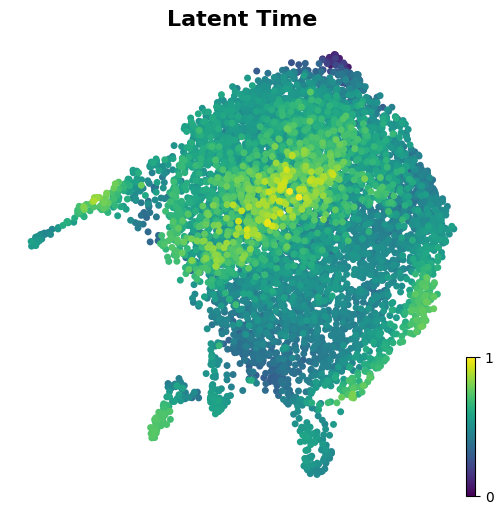

In [155]:
fig, ax1 = pl.subplots(1,1,figsize=(6,6))
ax1_dict = scv.pl.scatter(adata, color=['latent_time'], color_map='viridis', dpi=300, size=100, 
                          show = False, ax = ax1)
ax1.set_title("Latent Time", fontweight="bold", fontsize=16)
pl.savefig("Latent_Time.png")


<font size="5">Plot Lineage Gene Expression</font>

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)
Computing trends using `1` core(s)


  0%|          | 0/3 [00:00<?, ?gene/s]

    Finish (0:00:14)
Plotting trends


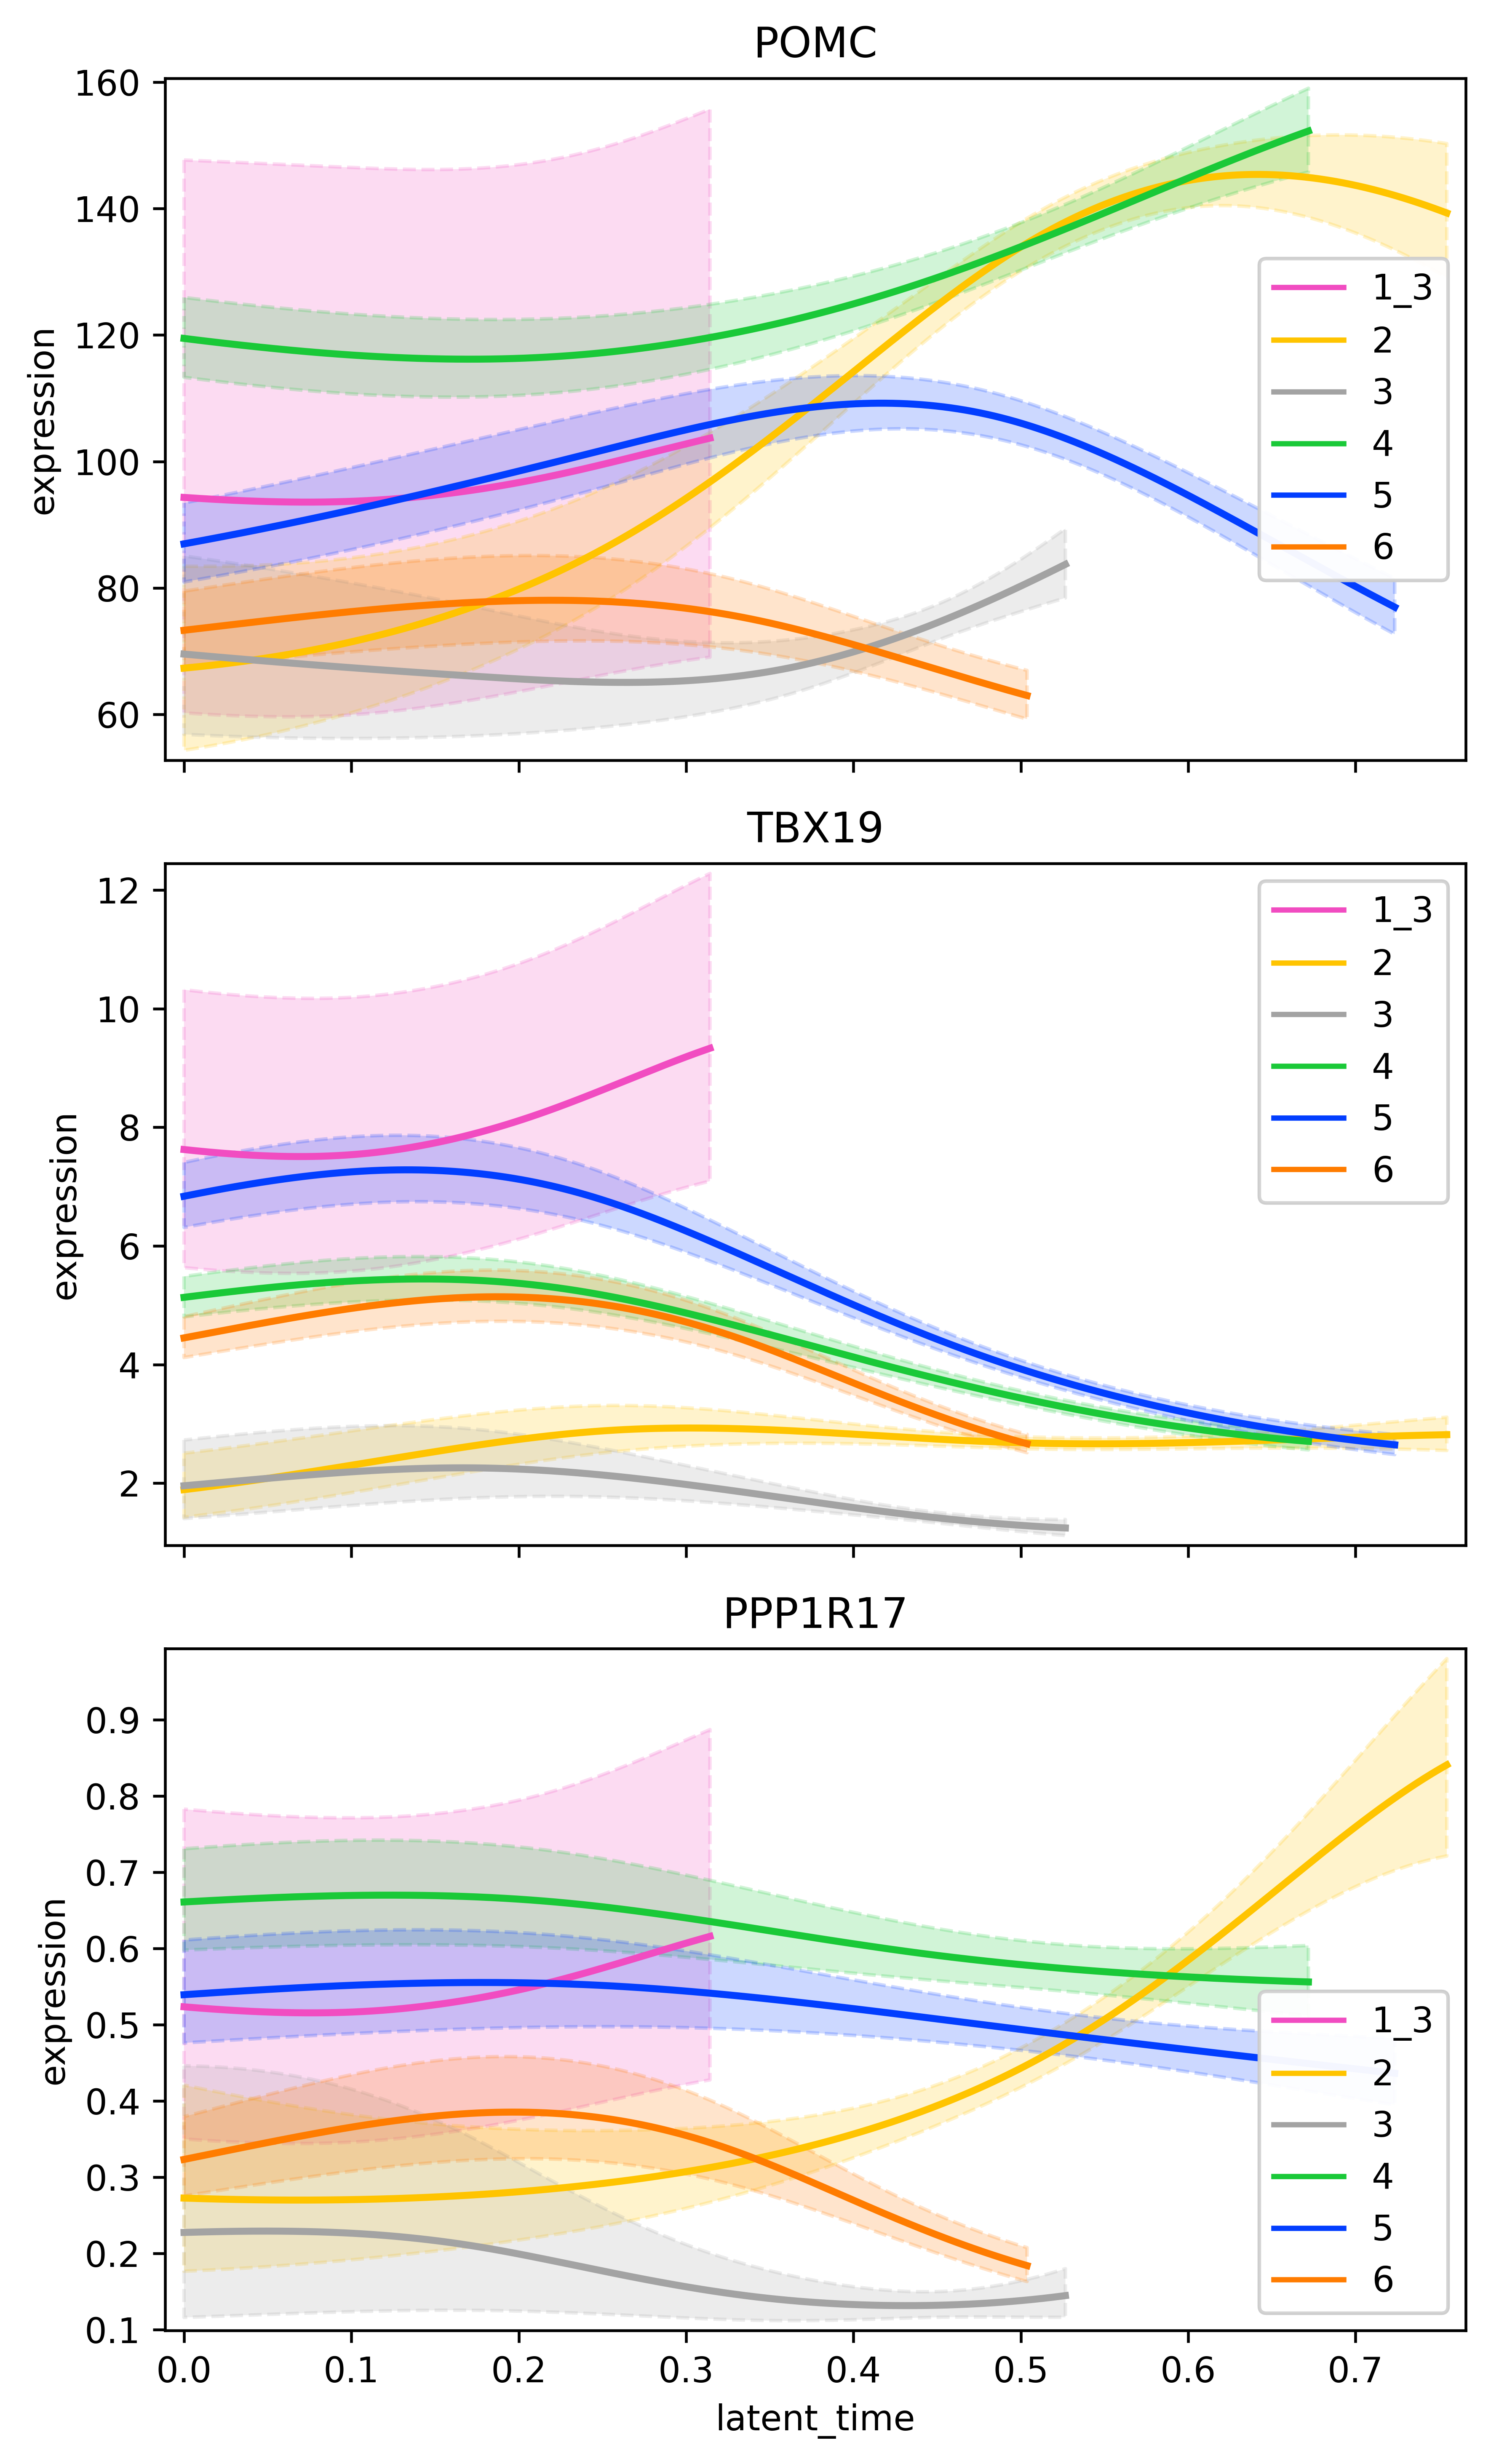

In [156]:
g.compute_lineage_drivers()
model = cr.models.GAM(adata)

cr.pl.gene_trends(
    adata,
    model=model,
    data_key="X",
    genes=["POMC", "TBX19",  "PPP1R17"],
    ncols=1,
    time_key="latent_time",
    same_plot=True,
    hide_cells=True,
    figsize=(6,10),
    n_test_points=500,
    use_raw=True,
    legend_loc="best",
    dpi =600,
    save="gene_trends.png"
    
)